<a href="https://colab.research.google.com/github/elenipapadopoulou4/thesis-code/blob/main/Emotion_Recognition_RAFDB_data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

"EmoLabel/list_patition_label.txt" <br>

*Number to Emotion* <br>
1: Surprise  <br>
2: Fear  <br>
3: Disgust  <br>
4: Happiness  <br>
5: Sadness  <br>
6: Anger  <br>
7: Neutral  <br>


In [ ]:
import tensorflow as tf

import os 
import matplotlib.pyplot as plt

import numpy as np
import cv2


import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout

from sklearn.metrics import classification_report, confusion_matrix,recall_score,f1_score
from tensorflow.keras.callbacks import ModelCheckpoint 


import matplotlib.image as mpimg

from keras.models import model_from_json
import json

from keras import backend as K


from PIL import Image

from collections import Counter
from tabulate import tabulate

import joblib

import shutil




In [ ]:
from google.colab import drive
drive.mount("/content/gdrive",force_remount=True)

Mounted at /content/gdrive


#RAF-DB

In [ ]:
def num_info(category,num):
  info = None
  if category=='gender':
    if num==0: info = 'Male'
    elif num==1: info = 'Female'
    elif num==2:info = 'Unsure'
  elif category=='race':
    if num==0: info = 'Cauasian'
    elif num==1: info = 'African-American'
    elif num==2: info = 'Asian'
  elif category=='age':
    if num==0: info = '0-3'
    elif num==1: info = '4-19'
    elif num==2: info = '20-39'
    elif num==3: info = '40-69'
    elif num==4: info = '70+'
  return info
  

RAF-DB annotations <br>

>>GENDER
*   0 -> male
*   1 -> female
*   2 -> unsure

>>RACE 
*   0 -> Cauasian (White)
*   1 -> African - American (Black)
*   2 -> Asian

>>Age 
*   0 -> 0-3
*   1 -> 4-19
*   2 -> 20-39
*   3 -> 40-69
*   4 -> 70+


In [ ]:
RAF_DB = '/content/gdrive/MyDrive/train_net/datasets/RAF-DB'
dataset_train_path = '/content/gdrive/MyDrive/train_net/datasets/RAF-DB/RAF-DB_aligned/train'
dataset_test_path = '/content/gdrive/MyDrive/train_net/datasets/RAF-DB/RAF-DB_aligned/test'

dataset_train_new = '/content/gdrive/MyDrive/train_net/datasets/RAF-DB/RAF-DB_directory/train'
dataset_test_new = '/content/gdrive/MyDrive/train_net/datasets/RAF-DB/RAF-DB_directory/test'

In [ ]:
#get RAF-DB manual annotations for age-gender-race

#get real values from json files
with open(os.path.join(RAF_DB,'age_true.json')) as json_file:
    age_true = json.load(json_file)
with open(os.path.join(RAF_DB,'gender_true.json')) as json_file:
    gender_true = json.load(json_file)
with open(os.path.join(RAF_DB,'race_true.json')) as json_file:
    race_true = json.load(json_file)

# Before split

In [ ]:
df_train = pd.read_csv('/content/gdrive/MyDrive/train_net/datasets/RAF-DB/RAF-DB_EmoLabel_train.csv', names=['Filename','Class'])


In [ ]:
df_test = pd.read_csv('/content/gdrive/MyDrive/train_net/datasets/RAF-DB/RAF-DB_EmoLabel_test.csv', names=['Filename','Class'])


In [ ]:
#create csv file with columns [image] [annotation] [gender] [race] [age] 

df_train_info = pd.read_csv('/content/gdrive/MyDrive/train_net/datasets/RAF-DB/RAF-DB_EmoLabel_train.csv', names=['Filename','Class'])
df_test_info = pd.read_csv('/content/gdrive/MyDrive/train_net/datasets/RAF-DB/RAF-DB_EmoLabel_test.csv', names=['Filename','Class'])



In [ ]:
df_train_info['gender'] = ' '
df_train_info['race'] = ' '
df_train_info['age'] = ' '

for filename in df_train_info['Filename']:
  df_train_info.loc[df_train_info.Filename ==	filename,'gender'] =  gender_true[filename[:-4]]
  df_train_info.loc[df_train_info.Filename ==	filename,'race'] =  race_true[filename[:-4]]
  df_train_info.loc[df_train_info.Filename ==	filename,'age'] =  age_true[filename[:-4]]

df_test_info['gender'] = ' '
df_test_info['race'] = ' '
df_test_info['age'] = ' '

for filename in df_test_info['Filename']:
  df_test_info.loc[df_test_info.Filename ==	filename,'gender'] =  gender_true[filename[:-4]]
  df_test_info.loc[df_test_info.Filename ==	filename,'race'] =  race_true[filename[:-4]]
  df_test_info.loc[df_test_info.Filename ==	filename,'age'] =  age_true[filename[:-4]]


In [ ]:
def emo_num(num):
  emo = None 
  if num == 1:
    emo ='Surprise'
  elif num == 2:
    emo = 'Fear'
  elif num == 3:
    emo = 'Disgust'
  elif num == 4:
    emo = 'Happiness'
  elif num == 5:
    emo = 'Sadness'
  elif num == 6:
    emo = 'Anger'
  elif num == 7:
    emo = 'Neutral'
  return emo


## seperate images to 7 directories

In [ ]:
#create csv file from txt file
'''
read_file = pd.read_csv (r'/content/gdrive/MyDrive/train_net/datasets/RAF-DB/RAF-DB_EmoLabel_train.txt', delimiter=' ', header=None)
read_file.to_csv (r'/content/gdrive/MyDrive/train_net/RAF-DB_EmoLabel_train.csv',header=None)

read_file = pd.read_csv (r'/content/gdrive/MyDrive/train_net/datasets/RAF-DB/RAF-DB_EmoLabel_test.txt',delimiter=' ', header=None)
read_file.to_csv (r'/content/gdrive/MyDrive/train_net/RAF-DB_EmoLabel_test.csv',header=None)
'''

In [ ]:
#TRAIN SET
#create 7 folders based on emotions 
df_train = pd.read_csv('/content/gdrive/MyDrive/train_net/datasets/RAF-DB/RAF-DB_EmoLabel_train.csv', names=['Filename','Class'])
print(df_train)
labels = df_train.sort_values('Class')

class_names = list(labels.Class.unique())

#make 7 directories for each class
for i in class_names:
    os.makedirs(os.path.join(dataset_train_new,str(i)))

#create path images
for class_name in class_names:      # for each class          
  for image_name in list(df_train[df_train['Class']== class_name]['Filename']):   #get images of that class    
    get_image = os.path.join(dataset_train_path,'train_{}_aligned.jpg'.format(image_name[6:11])) #get image original path
    move_image = shutil.copy(get_image,os.path.join(dataset_train_new,str(class_name))) #move image to class directory



In [ ]:
#TEST SET
#create 7 folders based on emotions 
df_test = pd.read_csv('/content/gdrive/MyDrive/train_net/datasets/RAF-DB/RAF-DB_EmoLabel_test.csv', names=['Filename','Class'])
print(df_test)
labels = df_test.sort_values('Class')

class_names = list(labels.Class.unique())


#make 7 directories for each class
for i in class_names:
    os.makedirs(os.path.join(dataset_test_new,str(i)))


#create path images
for class_name in class_names:  # for each class 
  print(class_name)             
  for image_name in list(df_test[df_test['Class']== class_name]['Filename']):   #get images of that class    
    get_image = os.path.join(dataset_test_path,'test_{}_aligned.jpg'.format(image_name[5:9])) #get image original path
    move_image = shutil.copy(get_image,os.path.join(dataset_test_new,str(class_name))) #move image to class directory

In [ ]:
#rename numerical values to emotions 
for dir in os.listdir(dataset_train_new): 
  os.rename(os.path.join(dataset_train_new,dir),os.path.join(dataset_train_new,emo_num(int(dir))))

for dir in os.listdir(dataset_test_new): 
  os.rename(os.path.join(dataset_test_new,dir),os.path.join(dataset_test_new,emo_num(int(dir))))

##Show data

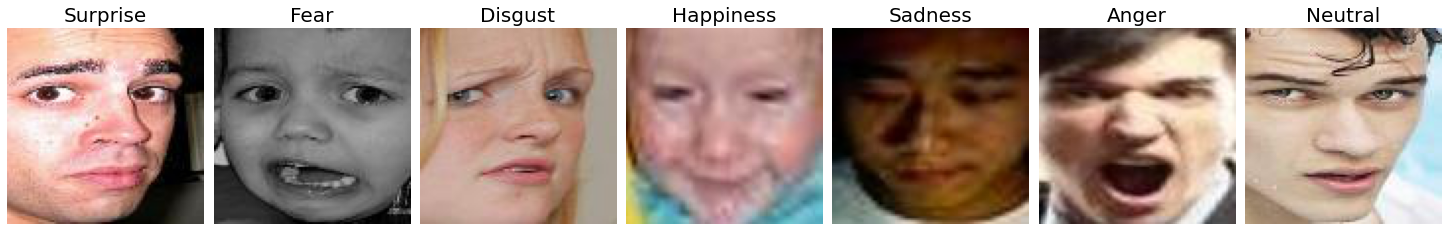

In [ ]:
fig, axs = plt.subplots(figsize=(20, 4), ncols=7, constrained_layout=True)
for i,category in enumerate(os.listdir(dataset_train_new)):
  category_path = os.path.join(dataset_train_new,category)
  image  =  mpimg.imread(os.path.join(category_path,os.listdir(category_path)[0]))
  axs[i].imshow(image)  
  axs[i].set_title(category,fontsize = 20)
  axs[i].axis("off")



## data preprocessing 

In [ ]:
# load one image
image = Image.open('/content/gdrive/MyDrive/train_net/datasets/RAF-DB/RAF-DB_directory/test/Anger/test_0017_aligned.jpg')
# convert image to numpy array
data = np.asarray(image)

In [ ]:
print(np.shape(data))

(100, 100, 3)


Οι εικόνες που στέλνουμε στο νευρωνικό δίκτυο είναι aligned και resized σε 100*100 και είναι έγχρωμες (τιμές απο 0-255). <br>
 Έτσι στο δίκτυο οι πίνακες είναι μεγέθους 100 * 100 * 3 

In [ ]:
cd /content/gdrive/MyDrive/train_net/datasets/RAF-DB/RAF-DB_directory

/content/gdrive/.shortcut-targets-by-id/1cslvEvVi7BMmq10J5-pjjOD2J9zkdWma/train_net/datasets/RAF-DB/RAF-DB_directory


In [ ]:
# get batches of tensor image data (rescaled to 0-1)
train_datagen = ImageDataGenerator(rescale=1./255,horizontal_flip=True,brightness_range=[0.2,1.0])
test_datagen = ImageDataGenerator(rescale=1./255,horizontal_flip=True,brightness_range=[0.2,1.0])

In [ ]:
batch_size = 32
# load and iterate training dataset
train_generator = train_datagen.flow_from_directory(
        './train',
        target_size=(100, 100),
        color_mode='rgb', # 3 channels
        batch_size=batch_size,
        class_mode='categorical')

# load and iterate validation dataset (test images)
validation_generator = test_datagen.flow_from_directory(
        './test',
        target_size=(100, 100),
        color_mode='rgb', # 3 channels
        batch_size=batch_size,
        class_mode='categorical')

Found 12271 images belonging to 7 classes.
Found 3068 images belonging to 7 classes.


## Class distribution

In [ ]:
train_counter = Counter(train_generator.classes)
val_counter = Counter(validation_generator.classes)

print(train_counter.items())
print(val_counter.items())

dict_items([(0, 705), (1, 717), (2, 281), (3, 4772), (4, 2524), (5, 1982), (6, 1290)])
dict_items([(0, 162), (1, 160), (2, 74), (3, 1185), (4, 680), (5, 478), (6, 329)])


In [ ]:
def get_key(val):
    for key, value in (validation_generator.class_indices).items():
         if val == value:
             return key
 
    return "key doesn't exist"

In [ ]:
images_counter = train_counter+val_counter
class_names_list = [get_key(emo_class) for emo_class in (images_counter).keys()]

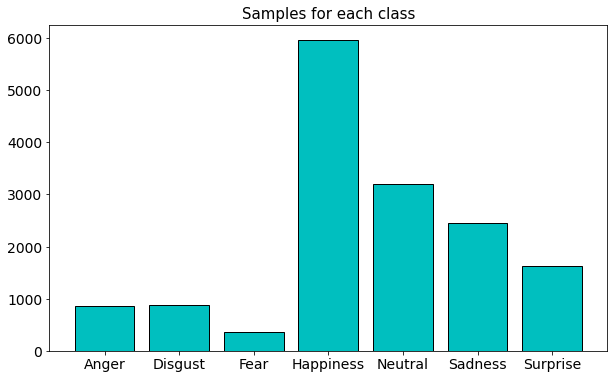

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(class_names_list,images_counter.values(),color='c',  edgecolor='black')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Samples for each class",fontsize=15)
plt.show()

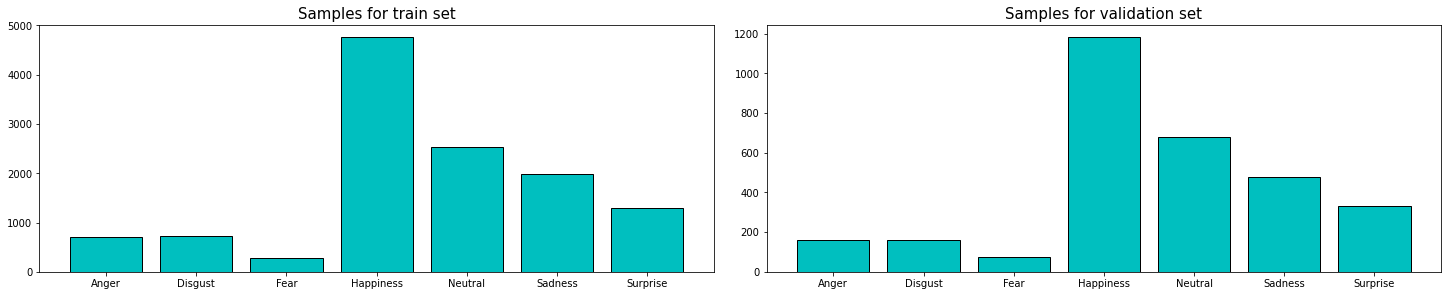

In [ ]:
fig, axs = plt.subplots(figsize=(20, 4), ncols=2, constrained_layout=True)
sets = ['train','validation']
for i,set_counter in enumerate([train_counter,val_counter]):
  names_list = [get_key(emo_class) for emo_class in (set_counter).keys()]
  axs[i].bar(names_list,set_counter.values(),color='c',  edgecolor='black')
  axs[i].set_title("Samples for {} set".format(sets[i]),fontsize=15)


In [ ]:
def plot_samples(category_name,names,counter_train,counter_val):
  f, axs = plt.subplots(2,2,figsize=(16,5))
  plt.subplot(1, 2, 1) # row 1, col 2 index 1
  plt.bar(names,counter_train,color='c',  edgecolor='black')
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  plt.title("{} for train set".format(category_name),fontsize=15)

  plt.subplot(1, 2, 2) # row 1, col 2 index 1
  plt.bar(names,counter_val,color='c',  edgecolor='black')
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  plt.title("{} for validation set".format(category_name),fontsize=15)
  plt.show()


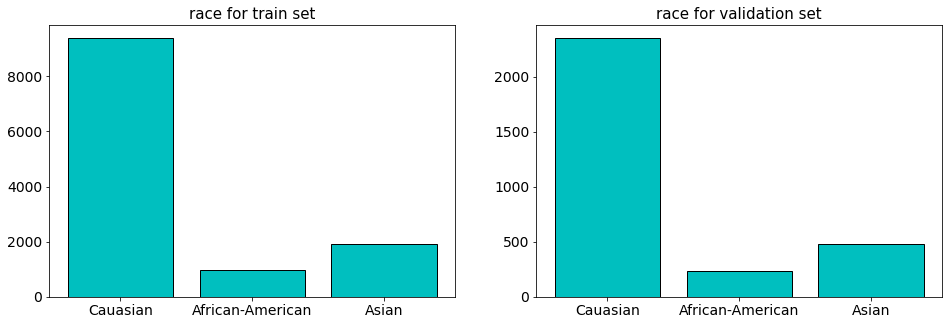

In [ ]:
race_names = ['Cauasian','African-American','Asian']
race_numbers = ['0','1','2']

race_counter_train = []
for i in range(len(race_names)):
  race_counter_train.append(len(df_train_info[df_train_info['race']==race_numbers[i]]))

race_counter_val = []
for i in range(len(race_names)):
  race_counter_val.append(len(df_test_info[df_test_info['race']==race_numbers[i]]))

plot_samples('race',race_names,race_counter_train,race_counter_val)


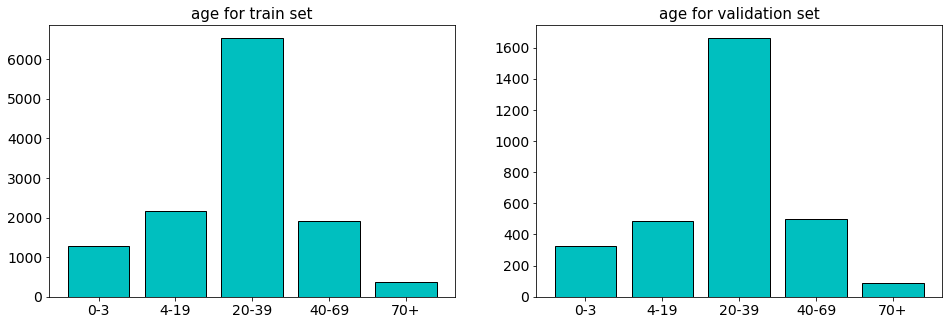

In [ ]:
age_names = ['0-3','4-19','20-39','40-69','70+']
age_numbers = ['0','1','2','3','4']


age_counter_train = []
for i in range(len(age_names)):
  age_counter_train.append(len(df_train_info[df_train_info['age']==age_numbers[i]]))

age_counter_val = []
for i in range(len(age_names)):
  age_counter_val.append(len(df_test_info[df_test_info['age']==age_numbers[i]]))

plot_samples('age',age_names,age_counter_train,age_counter_val)


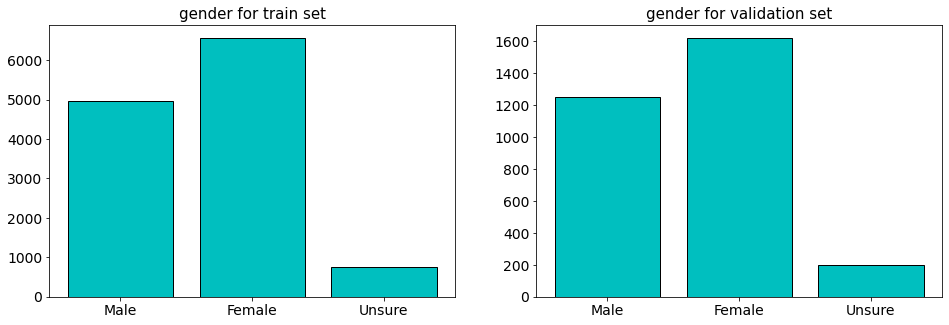

In [ ]:
gender_names = ['Male','Female','Unsure']
gender_numbers = ['0','1','2']

gender_counter_train = []
for i in range(len(gender_names)):
  gender_counter_train.append(len(df_train_info[df_train_info['gender']==gender_numbers[i]]))

gender_counter_val = []
for i in range(len(gender_names)):
  gender_counter_val.append(len(df_test_info[df_test_info['gender']==gender_numbers[i]]))

plot_samples('gender',gender_names,gender_counter_train,gender_counter_val)


## training

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


USE: Resnet50 pretrained model

In [ ]:
#our model
resnet_model = Sequential()

#pretrained model
pretrained_model= tf.keras.applications.ResNet50(
    include_top=False, #custume input and output layers based on our data
    weights="imagenet", #use weights from imagenet training 
    input_tensor=None,
    input_shape=(100,100,3),
    pooling='avg' , #average
)
     
resnet_model.add(pretrained_model)

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
# see layers of resnet 50
#pretrained_model.summary()

In [ ]:
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dropout(0.2))
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(7, activation='softmax'))

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 24,903,047
Trainable params: 24,849,927
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
resnet_model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy', f1_m])

In [ ]:
#checkpoint 
filepath = "/content/gdrive/MyDrive/train_net/ckp_models/RAFDB/RAFDB_aug/RAFDB_before_aug/RAFDB-{epoch:02d}.h5"
checkpoint = ModelCheckpoint(  
    filepath,
    monitor="val_loss",
    verbose=1,
    save_best_only=False,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch")

callbacks_list = [checkpoint]


#fit model
history = resnet_model.fit(train_generator,validation_data=validation_generator,epochs=10,callbacks=callbacks_list)


Epoch 1/10
384/384 [==============================] - ETA: 0s - loss: 1.0469 - accuracy: 0.6312 - f1_m: 0.5850 
Epoch 1: saving model to /content/gdrive/MyDrive/train_net/ckp_models/RAFDB_before/RAFDB-01.h5
384/384 [==============================] - 5897s 15s/step - loss: 1.0469 - accuracy: 0.6312 - f1_m: 0.5850 - val_loss: 5.6555 - val_accuracy: 0.3625 - val_f1_m: 0.3487
Epoch 2/10
384/384 [==============================] - ETA: 0s - loss: 0.6362 - accuracy: 0.7770 - f1_m: 0.7706
Epoch 2: saving model to /content/gdrive/MyDrive/train_net/ckp_models/RAFDB_before/RAFDB-02.h5
384/384 [==============================] - 52s 134ms/step - loss: 0.6362 - accuracy: 0.7770 - f1_m: 0.7706 - val_loss: 1.3706 - val_accuracy: 0.5346 - val_f1_m: 0.5204
Epoch 3/10
384/384 [==============================] - ETA: 0s - loss: 0.4683 - accuracy: 0.8370 - f1_m: 0.8353
Epoch 3: saving model to /content/gdrive/MyDrive/train_net/ckp_models/RAFDB_before/RAFDB-03.h5
384/384 [==============================] - 53

## evaluation


In [ ]:
# load and iterate test dataset (test images) --> the same as validation test but not Shuffled
test_generator = test_datagen.flow_from_directory(
        './test',
        target_size=(100, 100),
        color_mode='rgb', # 3 channels
        batch_size=32,
        class_mode='categorical',
        shuffle = False) # for predictions and truth to line up

Found 3068 images belonging to 7 classes.


In [ ]:
models_labels = {}
models_predictions = {}
models_directory = '/content/gdrive/MyDrive/train_net/ckp_models/RAFDB/RAFDB_aug/RAFDB_before_aug'
for saved_model in os.listdir(models_directory):
  model = tf.keras.models.load_model(os.path.join(models_directory,saved_model),custom_objects={'f1_m':f1_m})
  models_labels[saved_model[:-3]] = test_generator.classes
  Y_pred = model.predict(test_generator)
  models_predictions[saved_model[:-3]] = np.argmax(Y_pred, axis=1)


In [ ]:
#calculates f1 score and averaged accuracy
def f1_avgaccuracy(y_true,y_pred):
  f1 = f1_score(y_true,y_pred,average='macro')
  avg_accuracy = np.mean(recall_score(y_true, y_pred,average=None))
  
  return f1,avg_accuracy


In [ ]:
def predictions_labels_category(labels,predictions,category_list,category_dict):
  y_pred = {key: [] for key in category_list}
  y_true = {key: [] for key in category_list}
  category_counter = {key: [] for key in category_list} # values are list of indexes of each category


  for i,name in enumerate(test_generator.filenames): 
    image = name.rsplit('/')[1].rsplit('_',1)[0] 
    for cat in category_list:
      if category_dict[image] == cat:
        category_counter[cat].append(i)
        y_pred[cat].append(predictions[i])
        y_true[cat].append(labels[i])
    
  return y_true,y_pred,category_counter






In [ ]:
def results_category(split,category_list,category_names,category_name,y_true,y_pred,category_counter):
  print("{} scores {} split".format(category_name,split))
  data = []
  for i,cat in enumerate(category_list):
    data.append(["{}: {}".format(cat,category_names[i]),len(category_counter[cat]), f1_avgaccuracy(y_true[cat],y_pred[cat])[0],f1_avgaccuracy(y_true[cat],y_pred[cat])[1]])
  print(tabulate(data, headers=[category_name,"#images", "macro f1 score","averaged accuracy"]))
  print()



In [ ]:
for model_name in models_labels.keys():
  f1,avg_accuracy = f1_avgaccuracy(models_labels[model_name],models_predictions[model_name])
  print(" Model Name: {} f1score: {} AveragedAccuracy: {}".format(model_name,np.round(f1,3),round(avg_accuracy,3)))


 Model Name: RAFDB-01 f1score: 0.114 AveragedAccuracy: 0.152
 Model Name: RAFDB-02 f1score: 0.332 AveragedAccuracy: 0.341
 Model Name: RAFDB-03 f1score: 0.677 AveragedAccuracy: 0.642
 Model Name: RAFDB-04 f1score: 0.697 AveragedAccuracy: 0.696
 Model Name: RAFDB-05 f1score: 0.701 AveragedAccuracy: 0.677
 Model Name: RAFDB-06 f1score: 0.737 AveragedAccuracy: 0.731
 Model Name: RAFDB-07 f1score: 0.703 AveragedAccuracy: 0.684
 Model Name: RAFDB-08 f1score: 0.722 AveragedAccuracy: 0.695
 Model Name: RAFDB-09 f1score: 0.708 AveragedAccuracy: 0.684
 Model Name: RAFDB-10 f1score: 0.739 AveragedAccuracy: 0.719


In [ ]:
best_model_name = 'RAFDB-06'
best_model = tf.keras.models.load_model(os.path.join(models_directory,"{}.h5".format(best_model_name)),custom_objects={'f1_m':f1_m})


In [ ]:
RACES =['Cauasian','African-American','Asian']
races_num = ['0','1','2']
y_true_race,y_pred_race,counter_race = predictions_labels_category(models_labels[best_model_name],models_predictions[best_model_name],races_num,race_true)

AGES = ['0-3','4-19','20-39','40-69','70+']
ages_num = ['0','1','2','3','4']
y_true_age,y_pred_age,counter_age = predictions_labels_category(models_labels[best_model_name],models_predictions[best_model_name],ages_num,age_true)

GENDERS =['Male','Female','Unsure']
genders_num = ['0','1','2']
y_true_gender,y_pred_gender,counter_gender = predictions_labels_category(models_labels[best_model_name],models_predictions[best_model_name],genders_num,gender_true)


In [ ]:
print("OVERALL scores before split")
data = [[f1_avgaccuracy(models_labels[best_model_name],models_predictions[best_model_name])[0],f1_avgaccuracy(models_labels[best_model_name],models_predictions[best_model_name])[1]]]
print(tabulate(data, headers=["f1 score", "averaged accuracy"]))
print()
results_category('before',races_num,RACES,'race',y_true_race,y_pred_race,counter_race)
results_category('before',ages_num,AGES,'age',y_true_age,y_pred_age,counter_age)
results_category('before',genders_num,GENDERS,'gender',y_true_gender,y_pred_gender,counter_gender)


OVERALL scores before split
  f1 score    averaged accuracy
----------  -------------------
  0.737188             0.730699

race scores before split
race                   #images    macro f1 score    averaged accuracy
-------------------  ---------  ----------------  -------------------
0: Cauasian               2351          0.74165              0.733105
1: African-American        234          0.757485             0.802482
2: Asian                   483          0.678476             0.676905

age scores before split
age         #images    macro f1 score    averaged accuracy
--------  ---------  ----------------  -------------------
0: 0-3          329          0.538628             0.546342
1: 4-19         486          0.698854             0.69372
2: 20-39       1662          0.737365             0.722243
3: 40-69        502          0.683984             0.679943
4: 70+           89          0.506959             0.518984

gender scores before split
gender       #images    macro f1 sc

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and 

# After split

In [ ]:
#images directories (where the images are)
dataset_train_path = '/content/gdrive/MyDrive/train_net/datasets/RAF-DB/RAF-DB_aligned/train'
dataset_test_path = '/content/gdrive/MyDrive/train_net/datasets/RAF-DB/RAF-DB_aligned/test'

#fair directories 
dataset_train_fair = '/content/gdrive/MyDrive/train_net/datasets/RAF-DB/RAF-DB_directory_Fair/train'
dataset_val_fair= '/content/gdrive/MyDrive/train_net/datasets/RAF-DB/RAF-DB_directory_Fair/validation'
dataset_test_fair = '/content/gdrive/MyDrive/train_net/datasets/RAF-DB/RAF-DB_directory_Fair/test'

In [ ]:
df_info = pd.concat([df_train_info,df_test_info])

In [ ]:
df_info

,Filename,Class,gender,race,age
0,train_00001.jpg,5,1,0,2
1,train_00002.jpg,5,1,0,2
2,train_00003.jpg,4,1,2,2
3,train_00004.jpg,4,1,0,2
4,train_00005.jpg,5,1,2,1
...,...,...,...,...,...
3063,test_3064.jpg,7,2,0,0
3064,test_3065.jpg,7,0,0,2
3065,test_3066.jpg,7,1,2,2
3066,test_3067.jpg,7,0,0,2


In [ ]:
def train_val_test_split(category):
  len_list = len(category)
  train_per = int(len_list*0.55)
  val_per = int(len_list*0.15)
  test_per = int(len_list*0.30)
  
  train_category = list(category['Filename'][:train_per])
  val_category = list(category['Filename'][train_per:train_per+val_per])
  test_category = list(category['Filename'][train_per+val_per:])

  return train_category,val_category,test_category



In [ ]:
labels = df_train_info.sort_values('Class')
class_names = list(labels.Class.unique())

genders_num = ['0','1','2']
races_num = ['0','1','2']
ages_num = ['0','1','2','3','4']


In [ ]:
train_new = []
validation_new = []
test_new= []

for gender in genders_num:
  for race in races_num:
    for age in ages_num:
      for clas in class_names:
        print("gender:",gender,"race:",race,"age:",age,"class:",clas)
        df_category = df_info[(df_info['gender']==gender) & (df_info['race']==race) & (df_info['age']==age) & (df_info['Class']==clas)]      
        train_c,val_c,test_c = train_val_test_split(df_category)
        train_new.append(train_c)
        validation_new.append(val_c)
        test_new.append(test_c)
      
  

In [ ]:
train_list = list(np.concatenate(train_new).flat)
validation_list = list(np.concatenate(validation_new).flat)
test_list = list(np.concatenate(test_new).flat)


In [ ]:
len(train_list),len(validation_list),len(test_list)

(8327, 2206, 4806)

In [ ]:
df_train_fair = df_info[df_info['Filename'].isin(train_list)]
df_validation_fair = df_info[df_info['Filename'].isin(validation_list)]
df_test_fair = df_info[df_info['Filename'].isin(test_list)]

In [ ]:
df_train_fair

,Filename,Class,gender,race,age
0,train_00001.jpg,5,1,0,2
1,train_00002.jpg,5,1,0,2
2,train_00003.jpg,4,1,2,2
3,train_00004.jpg,4,1,0,2
4,train_00005.jpg,5,1,2,1
...,...,...,...,...,...
11747,train_11748.jpg,7,1,0,1
11774,train_11775.jpg,7,1,0,3
11779,train_11780.jpg,7,1,2,4
11809,train_11810.jpg,7,0,2,0


## seperate images to 7 directories

In [ ]:
#TRAIN SET
#make 7 directories for each class
for i in class_names:
    os.makedirs(os.path.join(dataset_train_fair,str(i)))

#create path images
for class_name in class_names:      # for each class          
  for image_name in list(df_train_fair[df_train_fair['Class']== class_name]['Filename']):   #get filename of that class
    if image_name[1]=='r': #trainfolder
      get_image = os.path.join(dataset_train_path,'train_{}_aligned.jpg'.format(image_name[6:11])) 
    elif image_name[1]=='e': #testfolder
      get_image = os.path.join(dataset_test_path,'test_{}_aligned.jpg'.format(image_name[5:9])) 
    move_image = shutil.copy(get_image,os.path.join(dataset_train_fair,str(class_name))) #move image to class directory


#VALIDATION SET
#make 7 directories for each class
for i in class_names:
    os.makedirs(os.path.join(dataset_val_fair,str(i)))

#create path images
for class_name in class_names:      # for each class          
  for image_name in list(df_validation_fair[df_validation_fair['Class']== class_name]['Filename']):   #get filename of that class
    if image_name[1]=='r': #trainfolder
      get_image = os.path.join(dataset_train_path,'train_{}_aligned.jpg'.format(image_name[6:11])) 
    elif image_name[1]=='e': #testfolder
      get_image = os.path.join(dataset_test_path,'test_{}_aligned.jpg'.format(image_name[5:9])) 
    move_image = shutil.copy(get_image,os.path.join(dataset_val_fair,str(class_name))) #move image to class directory


#TEST SET
#make 7 directories for each class
for i in class_names:
    os.makedirs(os.path.join(dataset_test_fair,str(i)))

#create path images
for class_name in class_names:      # for each class          
  for image_name in list(df_test_fair[df_test_fair['Class']== class_name]['Filename']):   #get filename of that class
    if image_name[1]=='r': #trainfolder
      get_image = os.path.join(dataset_train_path,'train_{}_aligned.jpg'.format(image_name[6:11])) 
    elif image_name[1]=='e': #testfolder
      get_image = os.path.join(dataset_test_path,'test_{}_aligned.jpg'.format(image_name[5:9])) 
    move_image = shutil.copy(get_image,os.path.join(dataset_test_fair,str(class_name))) #move image to class directory

In [ ]:
#rename numerical values to emotions 
for dir in os.listdir(dataset_train_fair): 
  os.rename(os.path.join(dataset_train_fair,dir),os.path.join(dataset_train_fair,emo_num(int(dir))))

for dir in os.listdir(dataset_val_fair): 
  os.rename(os.path.join(dataset_val_fair,dir),os.path.join(dataset_val_fair,emo_num(int(dir))))

for dir in os.listdir(dataset_test_fair): 
  os.rename(os.path.join(dataset_test_fair,dir),os.path.join(dataset_test_fair,emo_num(int(dir))))

##Show data

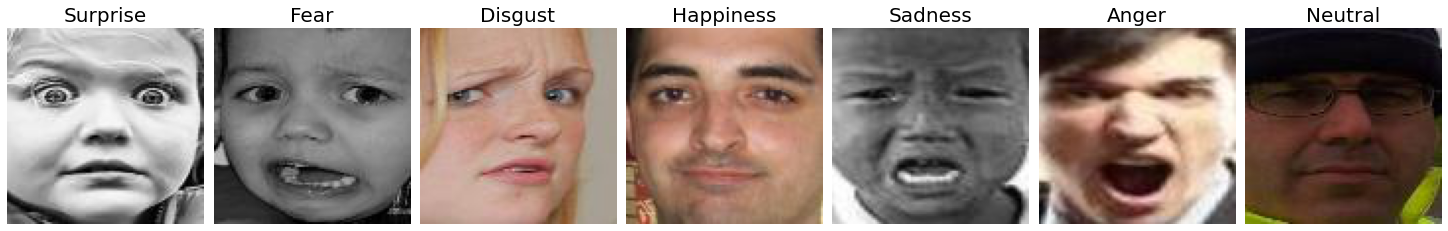

In [ ]:
fig, axs = plt.subplots(figsize=(20, 4), ncols=7, constrained_layout=True)
for i,category in enumerate(os.listdir(dataset_train_fair)):
  category_path = os.path.join(dataset_train_fair,category)
  image  =  mpimg.imread(os.path.join(category_path,os.listdir(category_path)[0]))
  axs[i].imshow(image)  
  axs[i].set_title(category,fontsize = 20)
  axs[i].axis("off")



## data preprocessing 

In [ ]:
# get batches of tensor image data (rescaled to 0-1)
train_datagen = ImageDataGenerator(rescale=1./255,horizontal_flip=True,brightness_range=[0.2,1.0])
val_datagen = ImageDataGenerator(rescale=1./255,horizontal_flip=True,brightness_range=[0.2,1.0])
test_datagen = ImageDataGenerator(rescale=1./255,horizontal_flip=True,brightness_range=[0.2,1.0])

In [ ]:
cd /content/gdrive/MyDrive/train_net/datasets/RAF-DB/RAF-DB_directory_Fair

/content/gdrive/.shortcut-targets-by-id/1cslvEvVi7BMmq10J5-pjjOD2J9zkdWma/train_net/datasets/RAF-DB/RAF-DB_directory_Fair


In [ ]:
batch_size = 32
# load and iterate training dataset
train_generator = train_datagen.flow_from_directory(
        './train',
        target_size=(100, 100),
        color_mode='rgb', # 3 channels
        batch_size=batch_size,
        class_mode='categorical')

# load and iterate validation dataset 
validation_generator = val_datagen.flow_from_directory(
        './validation',
        target_size=(100, 100),
        color_mode='rgb', # 3 channels
        batch_size=batch_size,
        class_mode='categorical')

# load and iterate test dataset 
test_generator = test_datagen.flow_from_directory(
        './test',
        target_size=(100, 100),
        color_mode='rgb', # 3 channels
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False) #test set

Found 8327 images belonging to 7 classes.
Found 2206 images belonging to 7 classes.
Found 4806 images belonging to 7 classes.


## Class distribution

In [ ]:
train_counter = Counter(train_generator.classes)
val_counter = Counter(validation_generator.classes)
test_counter = Counter(test_generator.classes)


print(train_counter.items())
print(val_counter.items())
print(test_counter.items())

dict_items([(0, 464), (1, 471), (2, 184), (3, 3260), (4, 1744), (5, 1332), (6, 872)])
dict_items([(0, 121), (1, 119), (2, 44), (3, 877), (4, 463), (5, 353), (6, 229)])
dict_items([(0, 282), (1, 287), (2, 127), (3, 1820), (4, 997), (5, 775), (6, 518)])


In [ ]:
def get_key(val):
    for key, value in (validation_generator.class_indices).items():
         if val == value:
             return key
 
    return "key doesn't exist"

In [ ]:
images_counter = train_counter+val_counter+test_counter
class_names_list = [get_key(emo_class) for emo_class in (images_counter).keys()]

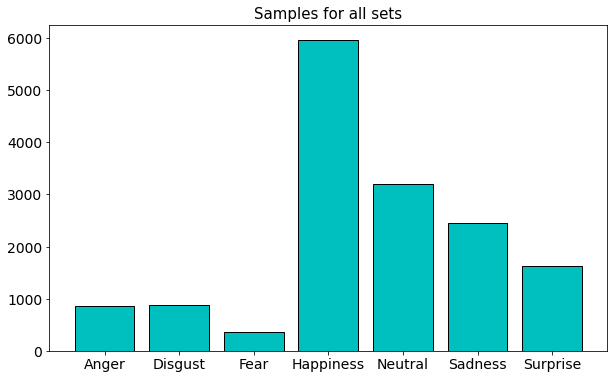

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(class_names_list,images_counter.values(),color='c',  edgecolor='black')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Samples for all sets",fontsize=15)
plt.show()

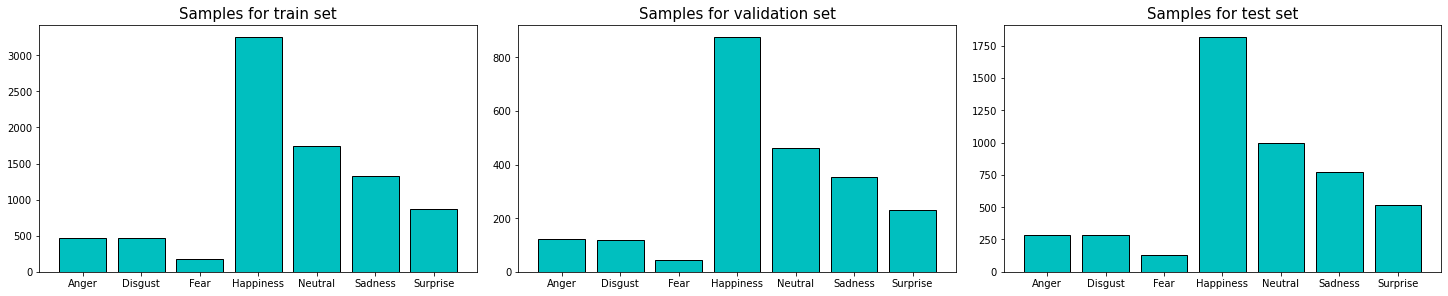

In [ ]:
fig, axs = plt.subplots(figsize=(20, 4), ncols=3, constrained_layout=True)
sets = ['train','validation','test']
for i,set_counter in enumerate([train_counter,val_counter,test_counter]):
  names_list = [get_key(emo_class) for emo_class in (set_counter).keys()]
  axs[i].bar(names_list,set_counter.values(),color='c',  edgecolor='black')
  axs[i].set_title("Samples for {} set".format(sets[i]),fontsize=15)


Παρατηρώ ότι μετά απο το fair split τα δεδομένα και στα 3 σύνολα έχουν την ίδια κατανομή 

In [ ]:
def plot_samples(category,names,train_counter,val_counter,test_counter):
  fig, axs = plt.subplots(figsize=(20, 4), ncols=3, constrained_layout=True)
  sets = ['train','validation','test']
  for i,set_counter in enumerate([train_counter,val_counter,test_counter]):
    names_list = [name for name in names]
    axs[i].bar(names_list,set_counter,color='c',  edgecolor='black')
    axs[i].set_title("{} distribution for {} set".format(category,sets[i]),fontsize=15)

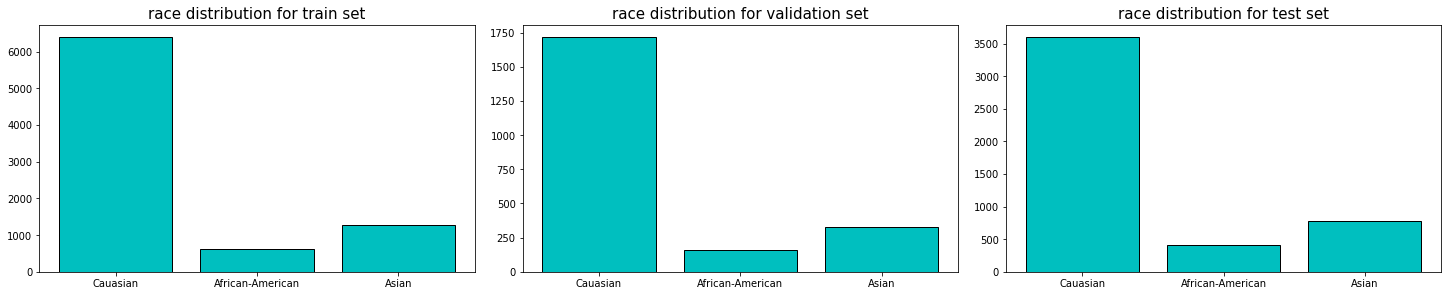

In [ ]:
race_names = ['Cauasian','African-American','Asian']
race_numbers = ['0','1','2']

race_counter_train = []
for i in range(len(race_names)):
  race_counter_train.append(len(df_train_fair[df_train_fair['race']==race_numbers[i]]))

race_counter_test = []
for i in range(len(race_names)):
  race_counter_test.append(len(df_test_fair[df_test_fair['race']==race_numbers[i]]))

race_counter_val = []
for i in range(len(race_names)):
  race_counter_val.append(len(df_validation_fair[df_validation_fair['race']==race_numbers[i]]))

plot_samples('race',race_names,race_counter_train,race_counter_val,race_counter_test)


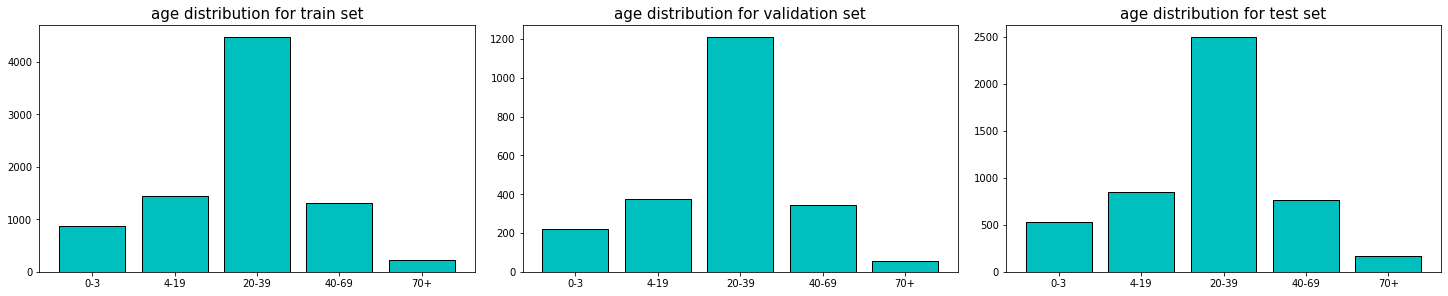

In [ ]:
age_names = ['0-3','4-19','20-39','40-69','70+']
age_numbers = ['0','1','2','3','4']


age_counter_train = []
for i in range(len(age_names)):
  age_counter_train.append(len(df_train_fair[df_train_fair['age']==age_numbers[i]]))

age_counter_val = []
for i in range(len(age_names)):
  age_counter_val.append(len(df_validation_fair[df_validation_fair['age']==age_numbers[i]]))

age_counter_test = []
for i in range(len(age_names)):
  age_counter_test.append(len(df_test_fair[df_test_fair['age']==age_numbers[i]]))

plot_samples('age',age_names,age_counter_train,age_counter_val,age_counter_test)


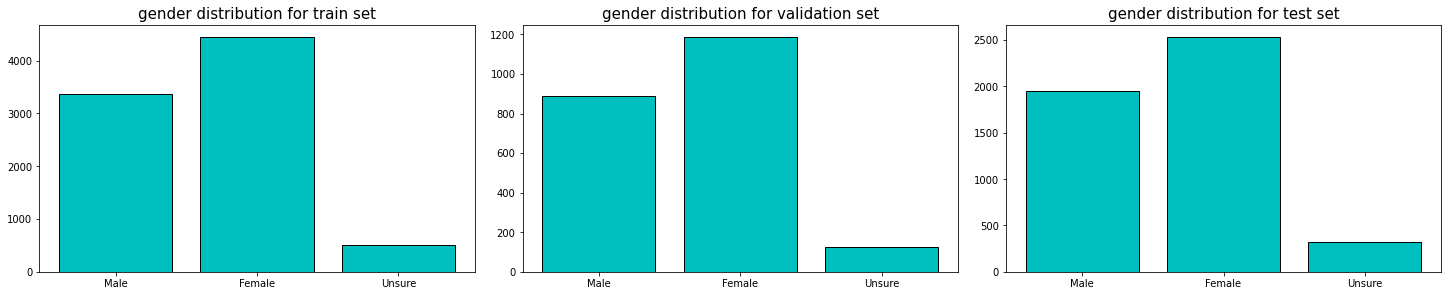

In [ ]:
gender_names = ['Male','Female','Unsure']
gender_numbers = ['0','1','2']

gender_counter_train = []
for i in range(len(gender_names)):
  gender_counter_train.append(len(df_train_fair[df_train_fair['gender']==gender_numbers[i]]))

gender_counter_val = []
for i in range(len(gender_names)):
  gender_counter_val.append(len(df_validation_fair[df_validation_fair['gender']==gender_numbers[i]]))

gender_counter_test = []
for i in range(len(gender_names)):
  gender_counter_test.append(len(df_test_fair[df_test_fair['gender']==gender_numbers[i]]))

plot_samples('gender',gender_names,gender_counter_train,gender_counter_val,gender_counter_test)


## training

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


USE: Resnet50 pretrained model

In [ ]:
#our model
resnet_model = Sequential()

#pretrained model
pretrained_model= tf.keras.applications.ResNet50(
    include_top=False, #custume input and output layers based on our data
    weights="imagenet", #use weights from imagenet training 
    input_tensor=None,
    input_shape=(100,100,3),
    pooling='avg' , #average
)
     
resnet_model.add(pretrained_model)

In [ ]:
# see layers of resnet 50
#pretrained_model.summary()

In [ ]:
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dropout(0.2))
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(7, activation='softmax'))

In [ ]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_3 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dense_5 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 24,903,047
Trainable params: 24,849,927
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
resnet_model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy', f1_m])

In [ ]:
#checkpoint 
filepath = "/content/gdrive/MyDrive/train_net/ckp_models/RAFDB/RAFDB_aug/RAFDB_after_aug/RAFDB-{epoch:02d}.h5"
checkpoint = ModelCheckpoint(  
    filepath,
    monitor="val_loss",
    verbose=1,
    save_best_only=False,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch")

callbacks_list = [checkpoint]


#fit model
history = resnet_model.fit(train_generator,validation_data=validation_generator,epochs=10,callbacks=callbacks_list)


Epoch 1/10
261/261 [==============================] - ETA: 0s - loss: 1.0981 - accuracy: 0.6099 - f1_m: 0.5621
Epoch 1: saving model to /content/gdrive/MyDrive/train_net/ckp_models/RAFDB_after/RAFDB-01.h5
261/261 [==============================] - 2252s 9s/step - loss: 1.0981 - accuracy: 0.6099 - f1_m: 0.5621 - val_loss: 5.5549 - val_accuracy: 0.3976 - val_f1_m: 0.3976
Epoch 2/10
261/261 [==============================] - ETA: 0s - loss: 0.6477 - accuracy: 0.7783 - f1_m: 0.7707
Epoch 2: saving model to /content/gdrive/MyDrive/train_net/ckp_models/RAFDB_after/RAFDB-02.h5
261/261 [==============================] - 36s 138ms/step - loss: 0.6477 - accuracy: 0.7783 - f1_m: 0.7707 - val_loss: 2.2658 - val_accuracy: 0.2348 - val_f1_m: 0.1837
Epoch 3/10
261/261 [==============================] - ETA: 0s - loss: 0.4677 - accuracy: 0.8420 - f1_m: 0.8397
Epoch 3: saving model to /content/gdrive/MyDrive/train_net/ckp_models/RAFDB_after/RAFDB-03.h5
261/261 [==============================] - 38s 146

## evaluation


In [ ]:
models_labels = {}
models_predictions = {}
models_directory = '/content/gdrive/MyDrive/train_net/ckp_models/RAFDB/RAFDB_aug/RAFDB_after_aug'
for saved_model in os.listdir(models_directory):
  model = tf.keras.models.load_model(os.path.join(models_directory,saved_model),custom_objects={'f1_m':f1_m})
  models_labels[saved_model[:-3]] = test_generator.classes
  Y_pred = model.predict(test_generator)
  models_predictions[saved_model[:-3]] = np.argmax(Y_pred, axis=1)


In [ ]:
for model_name in models_labels.keys():
  f1,avg_accuracy = f1_avgaccuracy(models_labels[model_name],models_predictions[model_name])
  print(" Model Name: {} f1score: {} AveragedAccuracy: {}".format(model_name,np.round(f1,3),round(avg_accuracy,3)))


 Model Name: RAFDB-01 f1score: 0.078 AveragedAccuracy: 0.143
 Model Name: RAFDB-02 f1score: 0.116 AveragedAccuracy: 0.169
 Model Name: RAFDB-03 f1score: 0.353 AveragedAccuracy: 0.363
 Model Name: RAFDB-04 f1score: 0.58 AveragedAccuracy: 0.552
 Model Name: RAFDB-05 f1score: 0.607 AveragedAccuracy: 0.595
 Model Name: RAFDB-06 f1score: 0.645 AveragedAccuracy: 0.661
 Model Name: RAFDB-07 f1score: 0.66 AveragedAccuracy: 0.655
 Model Name: RAFDB-08 f1score: 0.673 AveragedAccuracy: 0.649
 Model Name: RAFDB-09 f1score: 0.669 AveragedAccuracy: 0.663
 Model Name: RAFDB-10 f1score: 0.673 AveragedAccuracy: 0.634


In [ ]:
best_model_name = 'RAFDB-09'
best_model = tf.keras.models.load_model(os.path.join(models_directory,"{}.h5".format(best_model_name)),custom_objects={'f1_m':f1_m})


In [ ]:
RACES =['Cauasian','African-American','Asian']
races_num = ['0','1','2']
y_true_race,y_pred_race,counter_race = predictions_labels_category(models_labels[best_model_name],models_predictions[best_model_name],races_num,race_true)

AGES = ['0-3','4-19','20-39','40-69','70+']
ages_num = ['0','1','2','3','4']
y_true_age,y_pred_age,counter_age = predictions_labels_category(models_labels[best_model_name],models_predictions[best_model_name],ages_num,age_true)

GENDERS =['Male','Female','Unsure']
genders_num = ['0','1','2']
y_true_gender,y_pred_gender,counter_gender = predictions_labels_category(models_labels[best_model_name],models_predictions[best_model_name],genders_num,gender_true)


In [ ]:
print("OVERALL scores after split")
data = [[f1_avgaccuracy(models_labels[best_model_name],models_predictions[best_model_name])[0],f1_avgaccuracy(models_labels[best_model_name],models_predictions[best_model_name])[1]]]
print(tabulate(data, headers=["f1 score", "averaged accuracy"]))
print()
results_category('after',races_num,RACES,'race',y_true_race,y_pred_race,counter_race)
results_category('after',ages_num,AGES,'age',y_true_age,y_pred_age,counter_age)
results_category('after',genders_num,GENDERS,'gender',y_true_gender,y_pred_gender,counter_gender)


OVERALL scores after split
  f1 score    averaged accuracy
----------  -------------------
   0.66934             0.663105

race scores after split
race                   #images    macro f1 score    averaged accuracy
-------------------  ---------  ----------------  -------------------
0: Cauasian               3610          0.672716             0.665222
1: African-American        415          0.643024             0.663915
2: Asian                   781          0.641419             0.634538

age scores after split
age         #images    macro f1 score    averaged accuracy
--------  ---------  ----------------  -------------------
0: 0-3          528          0.611223             0.639228
1: 4-19         844          0.574585             0.593735
2: 20-39       2501          0.671187             0.657506
3: 40-69        766          0.664735             0.667192
4: 70+          167          0.473206             0.537928

gender scores after split
gender       #images    macro f1 score

# Results

before split <br>
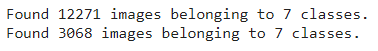

Παρατηρήσεις: <br>
*  Overall f1 score & avg accuract better before split <BR>
AFTER SPLIT: 
>> smaller training set <BR>
>> bigger test set 

* Τα αποτελέσματα για κάθε κατηγορία πριν και μετά το split είναι πανομοιότυπα. (Κατηγρορίες με χαμηλότερα/υψηλότερα αποτελέσματα πριν, συνεχίζουν να έχουν χαμηλότερα/υψηλότερα αποτελέσματα μετά) <br>
Αυτό οφείλεται στο ότι οι βάσεις έχουν σχεδόν ίδια κατανομή για τις κατηγορίες συναισθήματα, εθνικότητα, ηλικία και φύλο στα 2 σύνολα εκπαίδευσης (train και test) πριν το split. 

* RAF-DB: Βελτίωση που επιφέρει η επιβολή του fair split είναι η δημιουργία του σύνολου επικύρωσης το οποίο έχει την ίδια κατανομή στις κατηγορίες με τα άλλα σύνολα δεδομένων. 

after split <br>
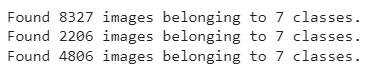